In [1]:
import os
import pandas as pd
import matplotlib.pylab as plt

# Preprocessing

In [22]:
train = pd.read_csv('data/train.csv',usecols=['target'])
test = pd.DataFrame()

In [23]:
foldernames = os.popen('ls data4stack').readlines()
foldernames

['lgb_stack\n',
 'mubi_20171125\n',
 'mubi_20171125_2\n',
 'mubi_20171125_3\n',
 'mubi_20171125_4\n',
 'mubi_20171125_5\n',
 'tian_20171126\n',
 'tian_20171126_1\n']

In [24]:
for foldername in foldernames:
    foldername = foldername[:-1]
    train[foldername] = pd.read_csv('data4stack//{0}/train4stack.csv'.format(foldername))
    test[foldername] = pd.read_csv('data4stack//{0}/test4stack.csv'.format(foldername))
train.head(1)

,target,lgb_stack,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0,0.040483,0.051245,0.04828,0.04864,0.049065,0.577594,0.069212,0.040211


In [25]:
test.head(1)

,lgb_stack,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0.029462,0.025915,0.027955,0.027292,0.030848,0.397098,0.039368,0.023685


In [26]:
new_cols = ['target','lgb_stack','xgb_mubi','lgb','lgb2','lgb3','GP','xgb_tian','rbf']
train.columns = new_cols
train.columns.values

array(['target', 'lgb_stack', 'xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP',
       'xgb_tian', 'rbf'], dtype=object)

In [28]:
new_cols = ['lgb_stack','xgb_mubi','lgb','lgb2','lgb3','GP','xgb_tian','rbf']
test.columns = new_cols
test.columns.values

array(['lgb_stack', 'xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP', 'xgb_tian',
       'rbf'], dtype=object)

In [29]:
train.to_csv('train4stack.csv',index = False)
test.to_csv('test4stack.csv',index = False)

In [30]:
y = train['target'].values
train.drop(['target'], axis=1, inplace=True)
train.columns.values

array(['lgb_stack', 'xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP', 'xgb_tian',
       'rbf'], dtype=object)

# Metric

In [10]:
def ginic(actual, pred):
    actual = np.asarray(actual) 
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalized(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)
    
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score


def gini_lgb(pred, dtrain):
    y = list(dtrain.get_label())
    score = ginic(y, pred) / ginic(y, y)
    return [('gini', score, True)]



# Model

In [11]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np

/Users/sue/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
params = {'eta': 0.025, 'max_depth': 4, 
            'alpha':4,'objective': 'binary:logistic',
          'eval_metric': 'auc', 'seed': 99, 'silent': True}

In [13]:
train_np = train.values
test_np = test.values

In [14]:
n_splits=5
test_pred = np.zeros(len(test_np)) 
skf = StratifiedKFold(n_splits, shuffle=True, random_state=99)
for i, (train_index,test_index) in enumerate(skf.split(train_np, y)):
    print("=====Round {0}/{1}=====".format(i+1,n_splits))
    x_train, x_valid = train_np[train_index], train_np[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    watchlist = [(xgb.DMatrix(x_train,y_train), 'train'), (xgb.DMatrix(x_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x_train,y_train), 1000, watchlist, feval=gini_xgb,
                    maximize=True, verbose_eval=100,  early_stopping_rounds=100)
   
    test_pred += model.predict(xgb.DMatrix(test_np),ntree_limit=model.best_ntree_limit)
        
test_pred /= n_splits

=====Round 1/5=====
[0]	train-gini:0.283168	valid-gini:0.286257
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.307134	valid-gini:0.301097
[200]	train-gini:0.314357	valid-gini:0.30221
Stopping. Best iteration:
[117]	train-gini:0.308804	valid-gini:0.302756

=====Round 2/5=====
[0]	train-gini:0.272244	valid-gini:0.273024
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.305934	valid-gini:0.301704
[200]	train-gini:0.313926	valid-gini:0.303303
Stopping. Best iteration:
[170]	train-gini:0.311851	valid-gini:0.303581

=====Round 3/5=====
[0]	train-gini:0.278403	valid-gini:0.258546
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.310599	valid-gini:0.29

In [15]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig
import operator

%matplotlib inline

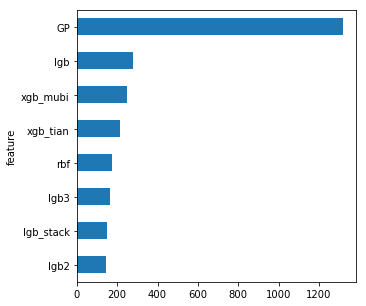

In [16]:
feature_names = list(train.columns.values)
create_feature_map(feature_names)

importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(5, 5))
#plt.gcf().savefig('features_importance_xgb_stack.png')

# Drop three single lgb models

In [32]:
train_drop = train.drop(['lgb','lgb2','lgb3'],axis=1)
train_drop.head(1)

,lgb_stack,xgb_mubi,GP,xgb_tian,rbf
0,0.040483,0.051245,0.577594,0.069212,0.040211


In [34]:
test_drop = test.drop(['lgb','lgb2','lgb3'],axis=1)
test_drop.head(1)

,lgb_stack,xgb_mubi,GP,xgb_tian,rbf
0,0.029462,0.025915,0.397098,0.039368,0.023685


In [35]:
train_drop_np = train_drop.values
test_drop_np = test_drop.values

In [36]:
params = {'eta': 0.02, 'max_depth': 4, 
            'alpha':4,'objective': 'binary:logistic',
          'eval_metric': 'auc', 'seed': 99, 'silent': True}

In [41]:
n_splits=3
test_pred = np.zeros(len(test_drop_np)) 
skf = StratifiedKFold(n_splits, shuffle=True, random_state=99)
for i, (train_index,test_index) in enumerate(skf.split(train_drop_np, y)):
    print("=====Round {0}/{1}=====".format(i+1,n_splits))
    x_train, x_valid = train_drop_np[train_index], train_drop_np[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    watchlist = [(xgb.DMatrix(x_train,y_train), 'train'), (xgb.DMatrix(x_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x_train,y_train), 1000, watchlist, feval=gini_xgb,
                    maximize=True, verbose_eval=100,  early_stopping_rounds=100)
   
    test_pred += model.predict(xgb.DMatrix(test_drop_np),ntree_limit=model.best_ntree_limit)
        
test_pred /= n_splits

=====Round 1/3=====
[0]	train-gini:0.271445	valid-gini:0.270318
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.306084	valid-gini:0.301304
[200]	train-gini:0.31161	valid-gini:0.302361
[300]	train-gini:0.318722	valid-gini:0.302702
Stopping. Best iteration:
[299]	train-gini:0.318693	valid-gini:0.302709

=====Round 2/3=====
[0]	train-gini:0.27984	valid-gini:0.266649
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.309148	valid-gini:0.295878
[200]	train-gini:0.314633	valid-gini:0.297204
Stopping. Best iteration:
[198]	train-gini:0.3146	valid-gini:0.297331

=====Round 3/3=====
[0]	train-gini:0.278089	valid-gini:0.280049
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds

In [43]:
n_splits=5
test_pred = np.zeros(len(test_drop_np)) 
skf = StratifiedKFold(n_splits, shuffle=True, random_state=99)
for i, (train_index,test_index) in enumerate(skf.split(train_drop_np, y)):
    print("=====Round {0}/{1}=====".format(i+1,n_splits))
    x_train, x_valid = train_drop_np[train_index], train_drop_np[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    watchlist = [(xgb.DMatrix(x_train,y_train), 'train'), (xgb.DMatrix(x_valid, y_valid), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x_train,y_train), 1000, watchlist, feval=gini_xgb,
                    maximize=True, verbose_eval=100,  early_stopping_rounds=100)
   
    test_pred += model.predict(xgb.DMatrix(test_drop_np),ntree_limit=model.best_ntree_limit)
        
test_pred /= n_splits

=====Round 1/5=====
[0]	train-gini:0.28319	valid-gini:0.286242
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.304944	valid-gini:0.302642
[200]	train-gini:0.310988	valid-gini:0.302022
Stopping. Best iteration:
[158]	train-gini:0.308476	valid-gini:0.30292

=====Round 2/5=====
[0]	train-gini:0.27225	valid-gini:0.273046
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.304732	valid-gini:0.302024
[200]	train-gini:0.310033	valid-gini:0.302674
Stopping. Best iteration:
[155]	train-gini:0.307941	valid-gini:0.303473

=====Round 3/5=====
[0]	train-gini:0.278403	valid-gini:0.258546
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.308782	valid-gini:0.2894

In [51]:
sub = pd.read_csv('data/sample_submission.csv')
sub.target = test_pred
sub.to_csv('xgb_stack_5models.csv',index=False)

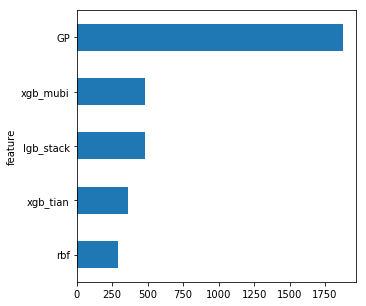

In [44]:
feature_names = list(train_drop.columns.values)
create_feature_map(feature_names)

importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(5, 5))
#plt.gcf().savefig('features_importance_xgb_stack.png')
# 5 fold

In [45]:
train_drop.head()

,lgb_stack,xgb_mubi,GP,xgb_tian,rbf
0,0.040483,0.051245,0.577594,0.069212,0.040211
1,0.031868,0.030891,0.464457,0.047779,0.022514
2,0.026850,0.020946,0.306400,0.030663,0.021269
3,0.024135,0.015791,0.285240,0.022902,0.015595
4,0.031031,0.027638,0.467099,0.054779,0.039256


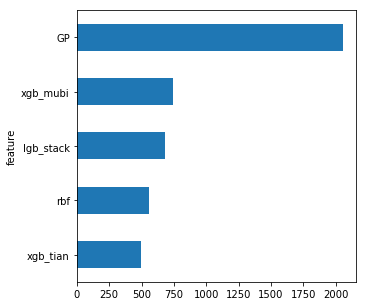

In [42]:
feature_names = list(train_drop.columns.values)
create_feature_map(feature_names)

importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(5, 5))
#plt.gcf().savefig('features_importance_xgb_stack.png')
# 3 fold

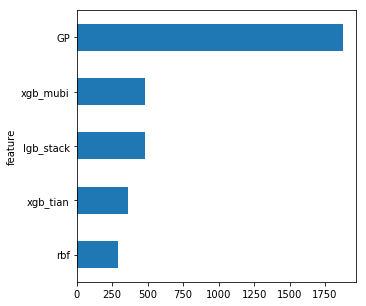

In [77]:
feature_names = list(train_drop.columns.values)
create_feature_map(feature_names)

importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(5, 5))
#plt.gcf().savefig('features_importance_xgb_stack.png')
# 5 fold

# Tune parameters of xgboost

### 1. Parameters max_depth and min_child_weight
#### Those parameters add constraints on the architecture of the trees.
* max_depth is the maximum number of nodes allowed from the root to the farthest leaf of a tree. 

In [78]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,12)
    for min_child_weight in range(1,8)
]

In [81]:
params = {'eta': 0.025, 'objective': 'binary:logistic',
          'eval_metric': 'auc', 'silent': True}

In [82]:
dtrain = xgb.DMatrix(train_drop_np, label=y)

In [98]:
num_boost_round=1200
min_gini = float("Inf")
best_params = 0
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=3,
        stratified=True,
        feval=gini_xgb,
        maximize=True,
        early_stopping_rounds=70,
        verbose_eval=20
    )
    
      # Update best gini
    mean_gini = cv_results['test-gini-mean'].max()
    boost_rounds = cv_results['test-gini-mean'].argmax()
    print("\tgini {} for {} rounds".format(mean_gini, boost_rounds))
    if mean_gini < min_gini:
        min_gini = mean_gini
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, gini: {}".format(best_params[0], best_params[1], min_gini))

CV with max_depth=4, min_child_weight=1
[0]	train-gini:0.297144+0.00345285	test-gini:0.293369+0.00683762
[20]	train-gini:0.303195+0.00488321	test-gini:0.297004+0.00622508
[40]	train-gini:0.305806+0.00390212	test-gini:0.298968+0.00647852
[60]	train-gini:0.306875+0.00391141	test-gini:0.299556+0.00663091
[80]	train-gini:0.307745+0.00373691	test-gini:0.300328+0.00699047
[100]	train-gini:0.309185+0.00310339	test-gini:0.300573+0.0071494
[120]	train-gini:0.310901+0.00294633	test-gini:0.300248+0.0067164
[140]	train-gini:0.311996+0.00310411	test-gini:0.300591+0.00704881
[160]	train-gini:0.313451+0.00308079	test-gini:0.300591+0.00721735
	gini 0.30086666666666667 for 102 rounds
CV with max_depth=4, min_child_weight=2
[0]	train-gini:0.297145+0.00404916	test-gini:0.293403+0.00688283
[20]	train-gini:0.303341+0.0043293	test-gini:0.296386+0.00605393
[40]	train-gini:0.305675+0.00372348	test-gini:0.298669+0.00655441
[60]	train-gini:0.306575+0.00366438	test-gini:0.299497+0.00706015
[80]	train-gini:0.3075

In [89]:
cv_results

,test-gini-mean,test-gini-std,train-gini-mean,train-gini-std
0,0.290482,0.009689,0.295346,0.002367


In [99]:
a

NameError: name 'a' is not defined

In [100]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,5)
    for min_child_weight in range(7,20)
]

In [ ]:
num_boost_round=1200
max_gini = None
best_params = 0
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=3,
        stratified=True,
        feval=gini_xgb,
        maximize=True,
        early_stopping_rounds=70,
        verbose_eval=50
    )
    
      # Update best gini
    mean_gini = cv_results['test-gini-mean'].max()
    boost_rounds = cv_results['test-gini-mean'].argmax()
    print("\tgini {} for {} rounds".format(mean_gini, boost_rounds))
    if max_gini==None or max_gini<mean_gini:
        max_gini = mean_gini
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, gini: {}".format(best_params[0], best_params[1], max_gini))

CV with max_depth=4, min_child_weight=7
[0]	train-gini:0.29706+0.00410843	test-gini:0.293504+0.00702409
[50]	train-gini:0.306478+0.00346336	test-gini:0.299234+0.00670893
[100]	train-gini:0.308587+0.00293945	test-gini:0.300685+0.0067998
[150]	train-gini:0.311784+0.00304384	test-gini:0.30076+0.00684188
[200]	train-gini:0.31548+0.00334971	test-gini:0.300328+0.00729031
	gini 0.30092366666666664 for 140 rounds
CV with max_depth=4, min_child_weight=8
[0]	train-gini:0.297175+0.00401061	test-gini:0.293371+0.00696888
[50]	train-gini:0.306154+0.0036565	test-gini:0.299441+0.00690598
[100]	train-gini:0.308708+0.00296987	test-gini:0.300754+0.00705377
[150]	train-gini:0.311789+0.00311075	test-gini:0.300861+0.0068503
	gini 0.30094133333333334 for 103 rounds
CV with max_depth=4, min_child_weight=9
[0]	train-gini:0.297175+0.00401061	test-gini:0.293371+0.00696888
[50]	train-gini:0.306272+0.00358394	test-gini:0.299621+0.00651332
[100]	train-gini:0.308534+0.00296471	test-gini:0.300703+0.0068951
[150]	trai